In [1]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import torch.optim as optim
import yaml


import sys
sys.path.append('../')
from src.conformer import *
from src.data_loader import *
from src.train import *

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
with open("../configs/training_config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Access hyperparameters
BATCH_SIZE = config["hyperparameters"]["BATCH_SIZE"]
NUM_EPOCHS = config["hyperparameters"]["NUM_EPOCHS"]
LEARNING_RATE = config["hyperparameters"]["LEARNING_RATE"]
WEIGHT_DECAY = config["hyperparameters"]["WEIGHT_DECAY"]

# Access model parameters
INPUT_DIM = config["model"]["INPUT_DIM"]
D_MODEL = config["model"]["D_MODEL"]
NUM_HEADS = config["model"]["NUM_HEADS"]
D_FF = config["model"]["D_FF"]
NUM_LAYERS = config["model"]["NUM_LAYERS"]
KERNEL_SIZE = config["model"]["KERNEL_SIZE"]
DROPOUT = config["model"]["DROPOUT"]
VOCAB_SIZE = config["model"]["VOCAB_SIZE"]
EARLY_STOPPING_PATIENCE = config["model"]["EARLY_STOPPING_PATIENCE"]
NO_IMPROVE_EPOCHS = config["model"]["NO_IMPROVE_EPOCHS"]

In [4]:
# Data paths
data_root = "../data"
    
# Create datasets
train_dataset = LibriSpeechDataset(root=data_root, split="train-clean-100")
val_dataset = LibriSpeechDataset(root=data_root, split="dev-clean")
    
# Create data loaders
train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=4
    )
    
val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4
    )
    
# Initialize model
model = Conformer(
        input_dim=INPUT_DIM,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        d_ff=D_FF,
        num_layers=NUM_LAYERS,
        kernel_size=KERNEL_SIZE,
        dropout=DROPOUT,
        vocab_size=VOCAB_SIZE
    ).to(device)

# Calculate model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Estimate model storage (in MB)
param_size = 4 # float32 size
storage_needed = total_params * param_size / (1024 ** 2)
print(f"Model storage required: {storage_needed:.2f} MB")
    
# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

warmup_epochs = 5  # Number of warmup epochs
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=LEARNING_RATE * 0.1)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#        optimizer, 'min', factor=0.5, patience=2, verbose=True
#    )

criterion = nn.CTCLoss(blank=train_dataset.blank_idx)

scaler = torch.cuda.amp.GradScaler()


Total parameters: 82,128,927
Model storage required: 313.30 MB


In [7]:
# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
    
for epoch in range(NUM_EPOCHS):
    # Train with mixed precision
    train_loss = train(model, train_loader, optimizer, criterion, device, epoch, scaler)
        
    # Evaluate
    val_loss = evaluate(model, val_loader, criterion, device)
        
    # Adjust learning rate
    scheduler.step(val_loss)
        
    # Save losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
        
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        

    # Save checkpoint every epoch
    torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, f"../models/conformer_checkpoint_epoch_{epoch+1}.pt")


    # Save model if validation loss improved and Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        NO_IMPROVE_EPOCHS = 0
        print(f"Saving best model with val loss: {val_loss:.4f}")
        torch.save(model.state_dict(), "../models/best_conformer_model.pt")
    else:
        NO_IMPROVE_EPOCHS += 1
        if NO_IMPROVE_EPOCHS >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 1 - Training: 100%|██████████| 7135/7135 [2:12:43<00:00,  1.12s/it, loss=0.757]  
/home/mehdi/Desktop/stt/stt_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/50 - Train Loss: 1.4089, Val Loss: 0.7044
Saving best model with val loss: 0.7044


Epoch 2 - Training: 100%|██████████| 7135/7135 [2:12:50<00:00,  1.12s/it, loss=0.387]  


Epoch 2/50 - Train Loss: 0.5874, Val Loss: 0.5881
Saving best model with val loss: 0.5881


Epoch 3 - Training: 100%|██████████| 7135/7135 [2:12:54<00:00,  1.12s/it, loss=0.388]  


Epoch 3/50 - Train Loss: 0.4604, Val Loss: 0.5125
Saving best model with val loss: 0.5125


Epoch 4 - Training: 100%|██████████| 7135/7135 [2:13:16<00:00,  1.12s/it, loss=0.539]  


Epoch 4/50 - Train Loss: 0.3878, Val Loss: 0.3999
Saving best model with val loss: 0.3999


Epoch 5 - Training: 100%|██████████| 7135/7135 [2:13:41<00:00,  1.12s/it, loss=0.224]  


Epoch 5/50 - Train Loss: 0.3232, Val Loss: 0.3553
Saving best model with val loss: 0.3553


Epoch 6 - Training: 100%|██████████| 7135/7135 [2:13:51<00:00,  1.13s/it, loss=0.266]  


Epoch 6/50 - Train Loss: 0.2735, Val Loss: 0.4395


Epoch 7 - Training: 100%|██████████| 7135/7135 [2:13:35<00:00,  1.12s/it, loss=0.186]  


Epoch 7/50 - Train Loss: 0.2683, Val Loss: 0.3783


Epoch 8 - Training: 100%|██████████| 7135/7135 [2:13:32<00:00,  1.12s/it, loss=0.0988]  


Epoch 8/50 - Train Loss: 0.2130, Val Loss: 0.3478
Saving best model with val loss: 0.3478


Epoch 9 - Training: 100%|██████████| 7135/7135 [2:13:29<00:00,  1.12s/it, loss=0.123]   


Epoch 9/50 - Train Loss: 0.2116, Val Loss: 0.3376
Saving best model with val loss: 0.3376


Epoch 10 - Training: 100%|██████████| 7135/7135 [2:13:30<00:00,  1.12s/it, loss=0.151]   


Epoch 10/50 - Train Loss: 0.1659, Val Loss: 0.3631


Epoch 11 - Training: 100%|██████████| 7135/7135 [2:12:58<00:00,  1.12s/it, loss=0.108]   


Epoch 11/50 - Train Loss: 0.1683, Val Loss: 0.3148
Saving best model with val loss: 0.3148


Epoch 12 - Training: 100%|██████████| 7135/7135 [2:12:43<00:00,  1.12s/it, loss=0.102]   


Epoch 12/50 - Train Loss: 0.1380, Val Loss: 0.3112
Saving best model with val loss: 0.3112


Epoch 13 - Training: 100%|██████████| 7135/7135 [2:12:57<00:00,  1.12s/it, loss=0.236]   


Epoch 13/50 - Train Loss: 0.1121, Val Loss: 0.3359


Epoch 14 - Training: 100%|██████████| 7135/7135 [2:13:27<00:00,  1.12s/it, loss=0.0864]  


Epoch 14/50 - Train Loss: 0.1194, Val Loss: 0.3541


Epoch 15 - Training: 100%|██████████| 7135/7135 [2:13:19<00:00,  1.12s/it, loss=0.298]   


Epoch 15/50 - Train Loss: 0.1125, Val Loss: 0.3182
Early stopping triggered.


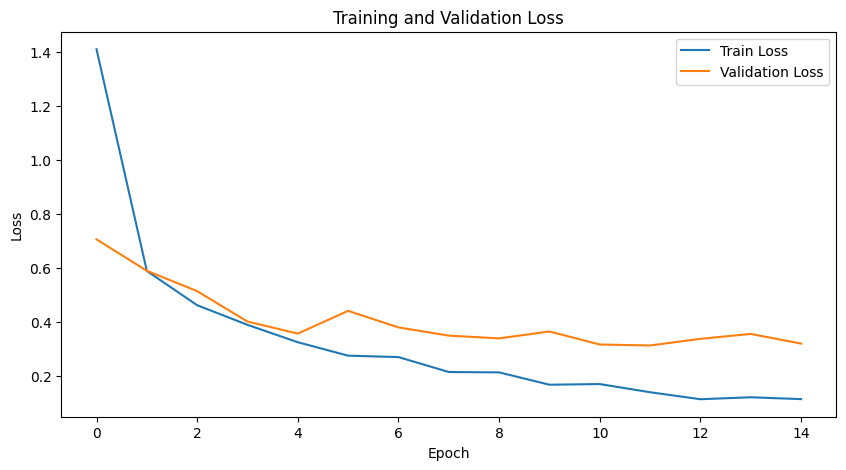

In [8]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('training_curve.png')
plt.show()